In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas
import geoplot #needs to be installed if not present

**In this task, I look at the NYPD Crime Statistics data from the NYPD_Year_To_Date_Complaints.csv file, and try to build visualizations and make inferences about the data and crime patterns.**

In [5]:
df = pd.read_csv('/content/drive/MyDrive/NYPD_Year_To_Date_Complaints.csv')

In [6]:
df.head()

,BORO_NAME,DATE,TIME,CATEGORY,LOCATION OF OCCURANCE,OFFENCE DESCRIPTION,PREMISE TYPE,SUSPECT AGE GROUP,SUSPECT RACE,SUSPECT SEX,VICTIM AGE GROUP,VICTIM RACE,VICTIM SEX,"LATITUDE, LONGITUDE"
0,BRONX,03/04/2023,12:55:00,FELONY,INSIDE,ROBBERY,BANK,UNKNOWN,BLACK,M,18-24,WHITE HISPANIC,M,"(40.822882, -73.848929)"
1,STATEN ISLAND,05/19/2023,15:52:00,FELONY,OUTSIDE,MURDER & NON-NEGL. MANSLAUGHTER,(null),<18,BLACK,M,<18,BLACK,M,NaN
2,BRONX,06/24/2023,14:35:00,VIOLATION,INSIDE,HARRASSMENT 2,(null),25-44,BLACK,M,45-64,BLACK,F,"(40.8673, -73.903374)"
3,MANHATTAN,04/01/2022,15:00:00,MISDEMEANOR,INSIDE,PETIT LARCENY,OTHER,25-44,ASIAN / PACIFIC ISLANDER,M,UNKNOWN,UNKNOWN,E,"(40.815904, -73.945123)"
4,MANHATTAN,12/29/2022,00:00:00,MISDEMEANOR,INSIDE,OFF. AGNST PUB ORD SENSBLTY &,RESIDENCE - APT. HOUSE,18-24,BLACK,M,18-24,BLACK HISPANIC,F,"(40.826268, -73.943126)"


## DEALING WITH MISSING VALUES

From a cursory glance, I can see that there are a few Nan entries, which correspond to missing data. There are also some non standard missing values, of the form '(null)', which could be a hindrance.

So I deal with non standard values by replacing those with the standard np.nan, and then checking total number of missing values now.

In [8]:
df = df.replace('(null)',np.nan)

In [9]:
df.isna().sum()

BORO_NAME                  431
DATE                         0
TIME                         0
CATEGORY                     0
LOCATION OF OCCURANCE    52942
OFFENCE DESCRIPTION         13
PREMISE TYPE              7714
SUSPECT AGE GROUP        36493
SUSPECT RACE             36493
SUSPECT SEX              36493
VICTIM AGE GROUP             0
VICTIM RACE                 49
VICTIM SEX                   0
LATITUDE, LONGITUDE          5
dtype: int64

In [10]:
df.shape

(271717, 14)

So we can see that the maximum number of missing values now is around 50000, but the data has more than 270000 entries, hence we cna safely remove the missing values without skewing the dataset.

In [11]:
df.dropna(inplace=True)

## ANALYSIS IDEATION

Looking at the data, there are a variety of features, such as geographical data, temporal data, attacker and victim demographics, offence category, offence location and such.

I think each category can provide interesting insights, hence I have tried to work upon all of them, sometimes individually, sometimes in unison with other paramaters to get a better sense.

##SECTION 1: Location based Analysis

*IDEA 1.1: Distribution of crime occurrences in different areas of New York City*

Visualization tool used: **Geospatial Scatter Plot**

We have data about different boroughs of NYC, along with the latitude and longitude of each occurrence site. I am interested in finding out where exactly have these crimes occurred in the city, how many per borough and represent them on an actual map interface.

Now since, we have over 200000 crime occurrences, representing each point on a map will not be feasible, hence I will just plot out total crime occurrences per borough.

In [12]:
df_latlong = df['LATITUDE, LONGITUDE'].str.strip('()')                               \
                   .str.split(', ', expand=True)                   \
                   .rename(columns={0:'Latitude', 1:'Longitude'})

Separating out latitude and longitude parameters

In [13]:
df['Latitude'] = df_latlong['Latitude'].astype('float')
df['Longitude'] = df_latlong['Longitude'].astype('float')

Group the data by borough, count total crime occurrences

In [14]:
df_boro_counts = df.groupby('BORO_NAME').count()['CATEGORY']
df_boro = df.groupby('BORO_NAME').mean()
df_boro['Count'] = df_boro_counts
df_boro

<ipython-input-14-f8258699bc6e>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_boro = df.groupby('BORO_NAME').mean()


,Latitude,Longitude,Count
BORO_NAME,,,
BRONX,40.845018,-73.887528,41414
BROOKLYN,40.659023,-73.948775,50266
MANHATTAN,40.769629,-73.971862,47556
QUEENS,40.717458,-73.835070,38914
STATEN ISLAND,40.603183,-74.125413,8363


I am using GeoPandas to visually represent this data onto an actual map interface. The geoplot library in Python has a shapefile corresponding to boroughs in NYC, which I can use with the right coordinate referencing system to show my data.

In [15]:
gdf = geopandas.GeoDataFrame(
    df_boro, geometry=geopandas.points_from_xy(df_boro.Longitude, df_boro.Latitude), crs="EPSG:4326"
)

In [16]:
boroughs = geopandas.read_file(geoplot.datasets.get_path('nyc_boroughs'))

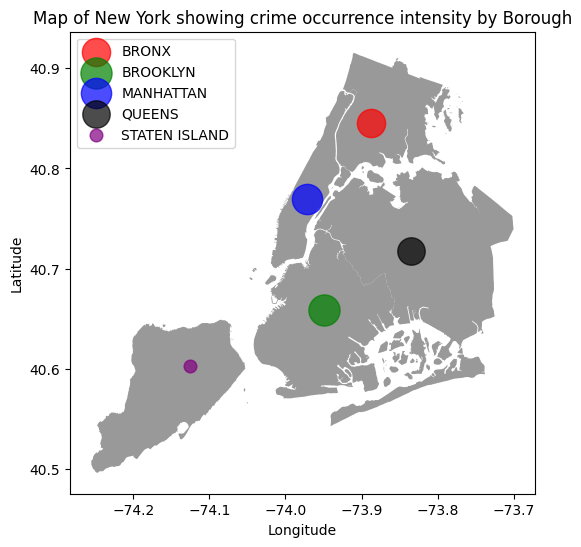

In [17]:
fig,ax=plt.subplots(figsize=(6,6))
boroughs.plot(ax=ax,alpha=0.8,color="grey")
gdf[gdf.index=='BRONX'].plot(ax=ax,markersize=gdf[gdf.index=='BRONX']['Count']/100,color='Red',marker='o',label='BRONX',alpha=0.7)
gdf[gdf.index=='BROOKLYN'].plot(ax=ax,markersize=gdf[gdf.index=='BROOKLYN']['Count']/100,color='Green',marker='o',label='BROOKLYN',alpha=0.7)
gdf[gdf.index=='MANHATTAN'].plot(ax=ax,markersize=gdf[gdf.index=='MANHATTAN']['Count']/100,color='Blue',marker='o',label='MANHATTAN',alpha=0.7)
gdf[gdf.index=='QUEENS'].plot(ax=ax,markersize=gdf[gdf.index=='QUEENS']['Count']/100,color='Black',marker='o',label='QUEENS',alpha=0.7)
gdf[gdf.index=='STATEN ISLAND'].plot(ax=ax,markersize=gdf[gdf.index=='STATEN ISLAND']['Count']/100,color='Purple',marker='o',label='STATEN ISLAND',alpha=0.7)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Map of New York showing crime occurrence intensity by Borough")
plt.legend(prop={'size':10},loc='upper left')
plt.savefig('/content/drive/MyDrive/NYC-Boroughwise-Crimes.png')
plt.show()

**Insights**

As we saw from the table earlier and this graph, some boroughs have a much higher crime occurrence rate than others. In this graph, different colors of labeled points show different regions and their locations around NYC. **The size of the marker points correspond to the intensity of crime in the location.** We can visually se that Brooklyn, Manhattan and Bronx have the highest number of crimes, followed by Queens and then Staten Island is much lower.

**We can conclude that the areas of Brooklyn, Manhattan and Bronx are probably the more unsafe regions in New York City, more prone to crime.**

*IDEA 1.2: Distribution of crime occurrences by premise*

Visualization tool used: **Pie Chart**

This is a simpler visualization. The idea is to get an understanding of which places are more prone to a crime happening there. Are public or private spaces more secure?

We simply count the occurrence of each premise type and visualize the top 10 highest categories.

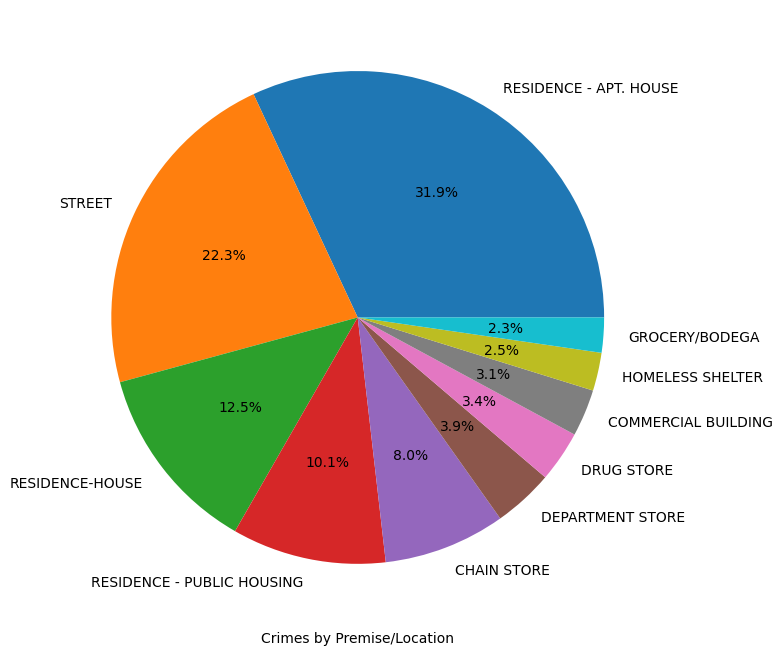

In [19]:
df_premise = df['PREMISE TYPE'].value_counts().iloc[:10]
fig, ax = plt.subplots(figsize=(12,8))
ax.pie(df_premise, labels=df_premise.index,autopct='%1.1f%%')
ax.set_xlabel('Crimes by Premise/Location')
plt.savefig('/content/drive/MyDrive/NYC-Premisewise-Crimes.png')
plt.show()

**Insights**

It can be seen from the graphs that **residential apartments** are the most susceptible to crimes with 31% of all crimes happening here. This is followed by the **Street** (public place) and **residential houses/townhomes**. It is an alamring fact to see that places of residence are crime hotspots.

Common areas such as the departmental store, drug store, grocery or banks are relatively safer, probably because they have better surveillance options available!

##SECTION 2: Temporal (Time based) Analysis

*IDEA 2.1: Hourly distribution of crimes, split by crime category*

Visualization tool used: **Multiple Bar Chart**

I noticed that there is a column in the dataset showing what time of day did the crime occur. I think it could be interesting to know whether there are certain time periods within 24 hours of the day when more crimes occur? Also, there are 3 categories of crime: Violation, Misdemeanor and Felony. It could be fun to learn how these are distributed across the day too!

In [20]:
df['CATEGORY'].value_counts()

MISDEMEANOR    90841
FELONY         60733
VIOLATION      34939
Name: CATEGORY, dtype: int64

I create time blocks of 2 hours each

In [21]:
conditions = [
    (df['TIME'] <= '02:00:00'),
    (df['TIME'] > '02:00:00') & (df['TIME'] <= '04:00:00'),
    (df['TIME'] > '04:00:00') & (df['TIME'] <= '06:00:00'),
    (df['TIME'] > '06:00:00') & (df['TIME'] <= '08:00:00'),
    (df['TIME'] > '08:00:00') & (df['TIME'] <= '10:00:00'),
    (df['TIME'] > '10:00:00') & (df['TIME'] <= '12:00:00'),
    (df['TIME'] > '12:00:00') & (df['TIME'] <= '14:00:00'),
    (df['TIME'] > '14:00:00') & (df['TIME'] <= '16:00:00'),
    (df['TIME'] > '16:00:00') & (df['TIME'] <= '18:00:00'),
    (df['TIME'] > '18:00:00') & (df['TIME'] <= '20:00:00'),
    (df['TIME'] > '20:00:00') & (df['TIME'] <= '22:00:00'),
    (df['TIME'] > '22:00:00')
    ]

values = ['12-2 am', '2-4 am', '4-6 am', '6-8 am', '8-10 am', '10 am-12 pm',
         '12-2 pm', '2-4 pm', '4-6 pm', '6-8 pm', '8-10 pm', '10 pm-12 am']

df['time_block'] = np.select(conditions, values)

Creation of filtered dataframes corresponding to the 3 types of crimes

In [22]:
df_felony = df[df['CATEGORY']=='FELONY']
df_misdemeanor = df[df['CATEGORY']=='MISDEMEANOR']
df_violation = df[df['CATEGORY']=='VIOLATION']

Grouping the datasets by time block to get total crimes committed in each slot

In [23]:
hourwise_felony_counts = df_felony.groupby('time_block').count()['CATEGORY']
hourwise_misdemeanor_counts = df_misdemeanor.groupby('time_block').count()['CATEGORY']
hourwise_violation_counts = df_violation.groupby('time_block').count()['CATEGORY']

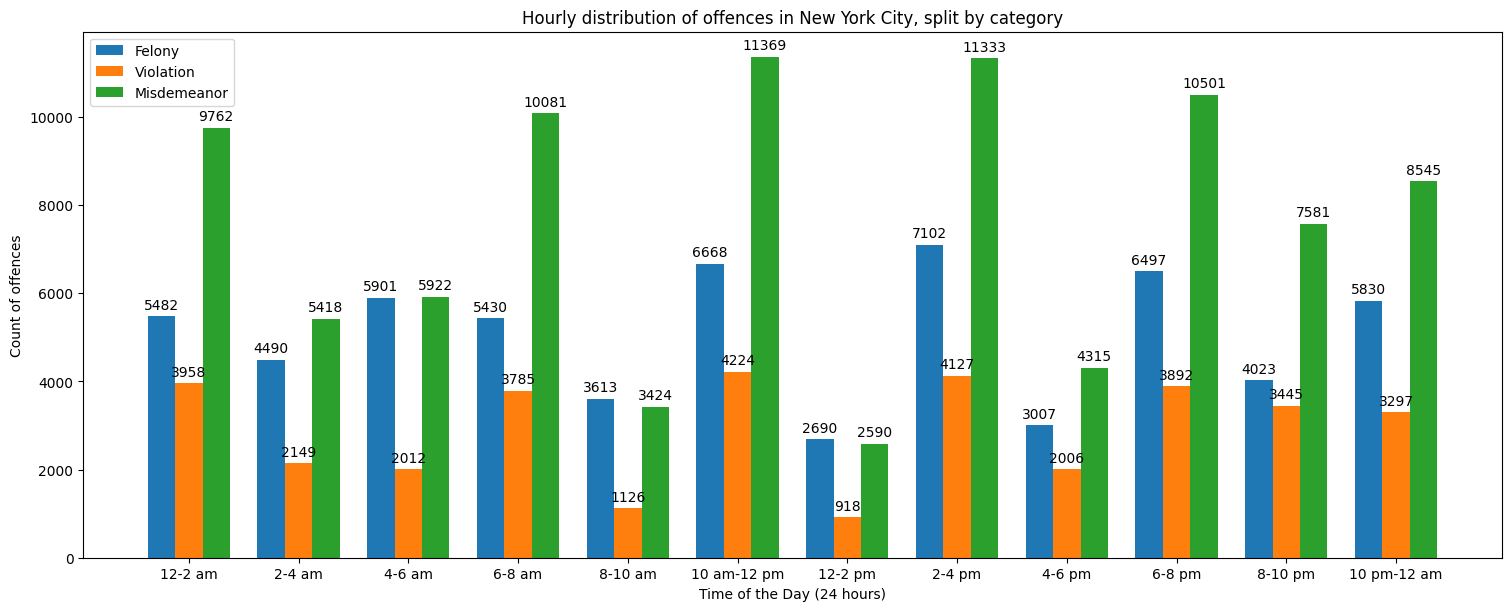

In [30]:
offence_means = {
    'Felony' : hourwise_felony_counts,
    'Violation' : hourwise_violation_counts,
    'Misdemeanor' : hourwise_misdemeanor_counts
}

x = np.arange(len(values))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(figsize=(15,6),layout='constrained')
for attribute, measurement in offence_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Count of offences')
ax.set_title('Hourly distribution of offences in New York City, split by category')
ax.set_xlabel('Time of the Day (24 hours)')
ax.set_xticks(x + width, values)
ax.legend(loc='upper left')
plt.savefig('/content/drive/MyDrive/Hourly-Crimes-by-Category.png')
plt.show()

**Insights**

This graph contains a plethora of information. First off, it can clearly be seen that **misdemeanor counts (in green) are much higher than any other crime category** with upto 10000 or more crimes per time block. **Felony count** are in the average, and **violations** are much lower.

Coming to the hourly spread, there is a reasonably higher number of crimes after dark, in the evening, night and dawn hours, as compared to daylight hours (morning, noon). Interestingly, the maximum number of crimes are occurring in the afternoon/evening time, which makes sense as people are leaving from work and hence public spaces are crowded and residences are empty!

*IDEA 2.2: Month on month distribution of crimes committed*

Visualization tool used: **Vertical Bar Chart**

I wanted to check if there is any seasonality w.r.t when crimes occur more frequently during the year. The original idea was to check yearly data, but it is skewed and with an uneven distribution, hence the results were not representative.

For this analysis, I extracted the month and year from the date string. Then I removed 2023 data, as it was not available for a complete year. I grouped the data by month and plotted out counts of crimes committed in each month.

In [34]:
df['month'] = df['DATE'].str.findall('(\d{2})').apply(lambda x: x[0])
df['year'] = df['DATE'].str.findall(r'(\d{4})').apply(lambda x: x[0])

In [35]:
df_2022 = df[df['year']!='2023']

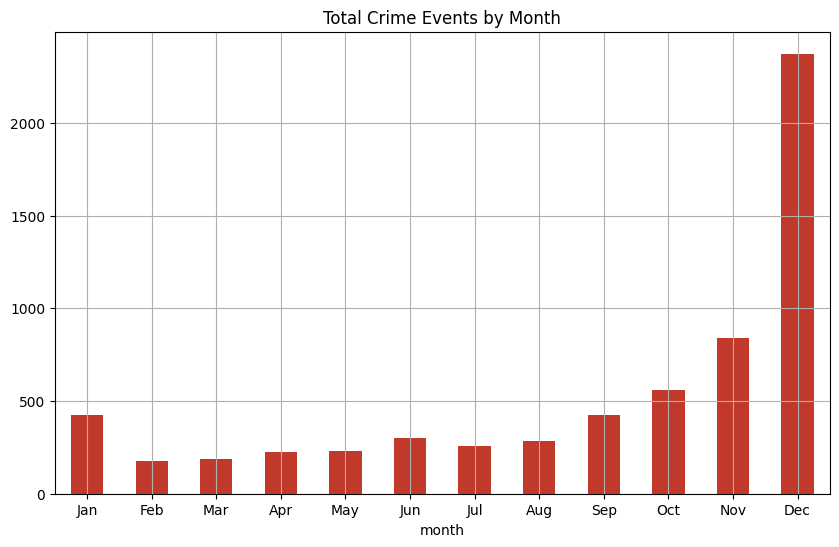

In [38]:
plt.figure(figsize=(10,6))
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
df_2022.groupby('month').size().plot(kind = 'bar', title ='Total Crime Events by Month', color = '#C0392B',rot=0)
plt.xticks(np.arange(12),months)
plt.grid()
plt.savefig('/content/drive/MyDrive/Monthly-Crimes-Distribution.png')
plt.show()

**Insights**

To my pleasant surprise, there is a very clearly evident trend in crimes committed per month! The number of crimes start off low at the year beginning, increases gradually and peaks substantially in the months of **November and December**

This has a **clear correlation to holiday season, more people in public spaces, tourism season in New York City**, therefore crimes would definitely shoot higher!

## SECTION 3: Demographics based Analysis

*IDEA 3.1: Demographic distribution of victims and suspects*

Visualization tool used: **Tabular Representations**

The dataset has columns corresponding to suspects and victims' age group, sex and race. I figure it would be intriguing to know if there are people belonging to a particular section of the population who are being attacked more, or vice versa, perpetrating more attacks!

I remove 'Unknown' values from all 3 parameters and only consider semantically explainable values. I then make filter datasets for victims and suspects. Grouping is carried out based on all 3 factors together and top 10 highest contributors are represented.

In [39]:
df_suspect = df[df['SUSPECT RACE']!='UNKNOWN']
df_suspect = df_suspect[df_suspect['SUSPECT SEX'].isin(['M','F'])]
df_suspect = df_suspect[df_suspect['SUSPECT AGE GROUP'].isin(['18-24','<18','25-44','45-64','65'])]

In [40]:
df_victim = df[df['VICTIM RACE']!='UNKNOWN']
df_victim = df_victim[df_victim['VICTIM SEX'].isin(['M','F'])]
df_victim = df_victim[df_victim['VICTIM AGE GROUP'].isin(['18-24','<18','25-44','45-64','65'])]

In [56]:
grouped_suspects = df_suspect.groupby(['SUSPECT SEX','SUSPECT RACE','SUSPECT AGE GROUP']).count()['CATEGORY'].sort_values(ascending=False).iloc[:10]
grouped_suspects = grouped_suspects.to_frame()
grouped_suspects.reset_index(inplace=True)
grouped_suspects.rename(columns = {'CATEGORY':'COUNT OF CRIMES'},inplace=True)
grouped_suspects.to_csv('/content/drive/MyDrive/Crime Suspect Demographics.csv',index=False)

In [57]:
grouped_suspects

,SUSPECT SEX,SUSPECT RACE,SUSPECT AGE GROUP,COUNT OF CRIMES
0,M,BLACK,25-44,19639
1,M,WHITE HISPANIC,25-44,10748
2,M,BLACK,45-64,7289
3,F,BLACK,25-44,6178
4,M,WHITE,25-44,4812
5,M,BLACK,18-24,4673
6,M,BLACK HISPANIC,25-44,3523
7,F,WHITE HISPANIC,25-44,3290
8,M,WHITE HISPANIC,45-64,3147
9,M,WHITE HISPANIC,18-24,2676


In [58]:
grouped_victims = df_victim.groupby(['VICTIM SEX','VICTIM RACE','VICTIM AGE GROUP']).count()['CATEGORY'].sort_values(ascending=False).iloc[:10]
grouped_victims = grouped_victims.to_frame()
grouped_victims.reset_index(inplace=True)
grouped_victims.rename(columns = {'CATEGORY':'COUNT OF CRIMES'},inplace=True)
grouped_victims.to_csv('/content/drive/MyDrive/Crime Victims Demographics.csv',index=False)

In [59]:
grouped_victims

,VICTIM SEX,VICTIM RACE,VICTIM AGE GROUP,COUNT OF CRIMES
0,F,BLACK,25-44,15407
1,F,WHITE HISPANIC,25-44,10623
2,M,BLACK,25-44,8299
3,F,BLACK,45-64,7222
4,M,WHITE HISPANIC,25-44,7202
5,F,WHITE,25-44,6096
6,M,WHITE,25-44,5567
7,M,BLACK,45-64,5412
8,F,WHITE HISPANIC,45-64,4109
9,M,WHITE,45-64,4059


**INSIGHTS**

*SUSPECTS*

**Black men in the age of 25-44 were the most frequent offenders**, with over 19000 cases, way higher than the **second category: white hispanic men in the same age group** (10000 cases). **The number of male offenders is substantially higher than the number of female offenders.** People in the age group **25-44** are most likely to be a criminal.

*VICTIMS*

In the victims chart, **Black Females in the age of 25-44 were subjected to the maximum number of crimes (15000)**, followed by **Hispanic females with around 10000 attacks.** **The number of female victims is significantly higher than the number of male victims.** People in the age group **45-64** are most likely to be attacked.

*IDEA 3.2: Distribution of Crime Activity by Offence type*

Visualization Tool Used: **Donut Chart**

This is a simpler visualization. The idea is to get an understanding of which types of offences are mosr prevalent. Kidnappings? Theft? Stabbing?

We simply count the occurrence of each offence type and visualize the top 10 highest categories.

In [60]:
df_offence = df['OFFENCE DESCRIPTION'].value_counts().iloc[:10]

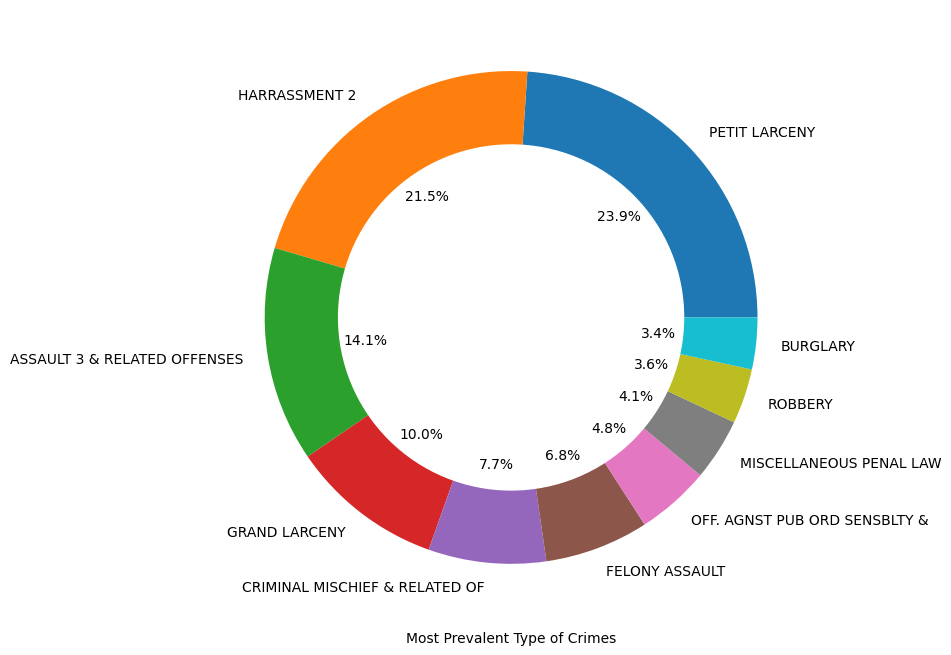

In [62]:
fig, ax = plt.subplots(figsize=(12,8))
ax.pie(df_offence, labels=df_offence.index,autopct='%1.1f%%')
my_circle = plt.Circle( (0,0), 0.7, color='white')
p = plt.gcf()
p.gca().add_artist(my_circle)
ax.set_xlabel('Most Prevalent Type of Crimes')
plt.savefig('/content/drive/MyDrive/Offence-Type-Distribution.png')
plt.show()

**Insights**

It can be seen from the graphs that **Petit Larceny** is the most common offence type in NYC (24%). Makes sense considering the city has a lot of pickpockets! **Harrassment and Assault** are also pretty prevalent (21% and 14%). This is also logically sensible considering the homeless/drug addict population in the city.

Burglary, Robbery or Felony Assaults are reasonably less prevalent!

Thus, I have created multiple visualizations relating to NYC Crime Statistics and derived inferences from the same. Digging into this data was an enjoyable process, it tested my skills, but I believe I have come up with a well rounded analysis piece!